# First, we'll start with a function that does 2D convolution manually 

In [60]:
# Imports 
import numpy as np
import matplotlib.pyplot as plt
import cv2

def gaussian_filter(size, sigma=1.0):
    size = int(size) // 2
    normal = 1 / (2 * np.pi * sigma**2)
    x, y = np.mgrid[-size:size+1,-size:size+1]
    g = np.exp(-((x**2 + y**2) / (2 * sigma**2))) * normal
    return g / np.sum(g)


def show_binary_image(image, title=None):
    # Converts from one colour space to the other. this is needed as RGB
    # is not the default colour space for OpenCV

    # Show the image

    plt.imshow(image, cmap=plt.cm.gray)

    # remove the axis / ticks for a clean looking image
    plt.xticks([])
    plt.yticks([])

    # if a title is provided, show it
    if title is not None:
        plt.title(title)

    plt.show()


sobel_x = np.array([
    [-1,0,1],
    [-2,0,2],
    [-1,0,1]
])

sobel_y = np.array([
    [1,2,1],
    [0,0,0],
    [-1,-2,-1]
])

In [61]:
import numpy as np

def two_d_conv(X: np.ndarray, k: np.ndarray, p: int or str = 0, s: int = 1) -> np.ndarray:
    if p == 'same':
        # Calculate padding to achieve 'same' convolution
        p = (k.shape[0] - 1) // 2

    p = int(p)
    s = int(s)
    
    # Padding the input
    num_rows, num_cols = X.shape
    padded_X = np.zeros((num_rows + 2*p, num_cols + 2*p))
    padded_X[p:p+num_rows, p:p+num_cols] = X
    X = padded_X
    
    # Calculating the output dimensions for 'same' convolution
    output_rows = (num_rows - k.shape[0] + 2*p) // s + 1
    output_cols = (num_cols - k.shape[1] + 2*p) // s + 1
    
    # Ensure output dimensions match input if 'same' padding is applied
    if p == (k.shape[0] - 1) // 2:
        output_rows = num_rows
        output_cols = num_cols

    output = np.zeros((output_rows, output_cols))
    
    # Performing convolution
    for i in range(output_rows):
        for j in range(output_cols):
            output[i, j] = np.sum(X[i*s:i*s+k.shape[0], j*s:j*s+k.shape[1]] * k)
    
    return output


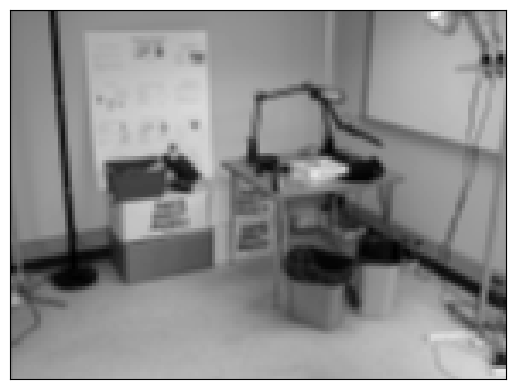

In [62]:

image = cv2.imread("images/cluttera2.jpg", cv2.IMREAD_GRAYSCALE)
gauss = gaussian_filter(15, 20)  
smoothed_image = two_d_conv(image, gauss, 
                            1, 7)
show_binary_image(smoothed_image) 

# Scale Invariant Feature Transform with Difference of Gaussians 

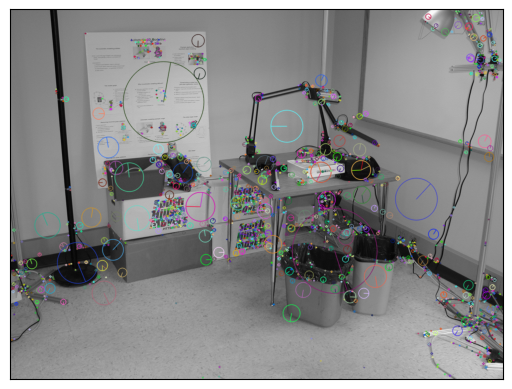

In [63]:
import numpy as np
import cv2 as cv
img = cv.imread('images/cluttera2.jpg')
gray= cv.cvtColor(img,cv.COLOR_BGR2GRAY)
sift = cv.SIFT_create()
kp = sift.detect(gray,None)
img=cv.drawKeypoints(gray,kp,img,flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
show_binary_image(img) 


1. Create the Gaussian Scale Space

In [64]:
def create_scale_space(image: np.ndarray, initial_sigma: float = 2.0, scale_space_size: int = 6) -> np.ndarray:
    gaussian_scale_space = np.zeros((scale_space_size, image.shape[0], image.shape[1]))
    current_sigma = initial_sigma
    for i in range(scale_space_size):
        g = gaussian_filter(9, current_sigma)
        smoothed_image = two_d_conv(image, g, p='same') 
        gaussian_scale_space[i] = smoothed_image
        current_sigma *= 2
    return gaussian_scale_space

image = cv.imread('images/cluttera2.jpg')
image= cv.cvtColor(image,cv.COLOR_BGR2GRAY)

scale_space = create_scale_space(image)
scale_space 
        

array([[[ 40.58872379,  52.74604665,  61.13321109, ...,  80.60862161,
          69.50726422,  53.42838034],
        [ 52.68827366,  68.46858924,  79.36008036, ..., 104.84503384,
          90.43978176,  69.54418586],
        [ 60.95010304,  79.20865112,  91.81873217, ..., 121.57192829,
         104.90926521,  80.7012899 ],
        ...,
        [ 77.00820737, 100.17028633, 116.06389431, ..., 143.86141948,
         123.95055289,  95.24999937],
        [ 66.48676059,  86.50984838, 100.2238644 , ..., 123.59208686,
         106.46090472,  81.79441478],
        [ 51.1864648 ,  66.6025137 ,  77.13220021, ...,  94.71113875,
          81.58432484,  62.66876153]],

       [[ 35.95803756,  44.32721241,  51.91897833, ...,  68.54585049,
          58.56206728,  47.58855865],
        [ 44.30858398,  54.59132113,  63.94734169, ...,  84.36199976,
          72.10352414,  58.61339366],
        [ 51.7680331 ,  63.78904426,  74.73461983, ...,  98.74885294,
          84.39077197,  68.5914179 ],
        ...,


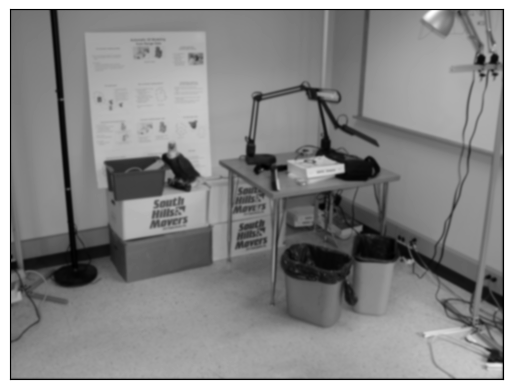

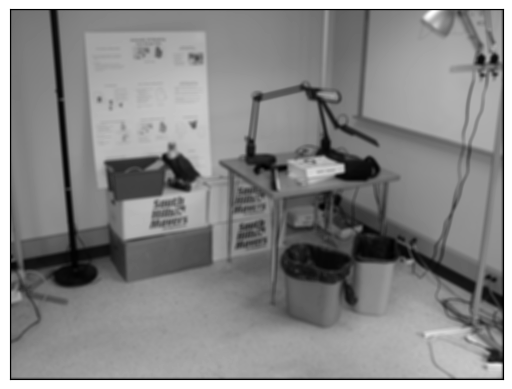

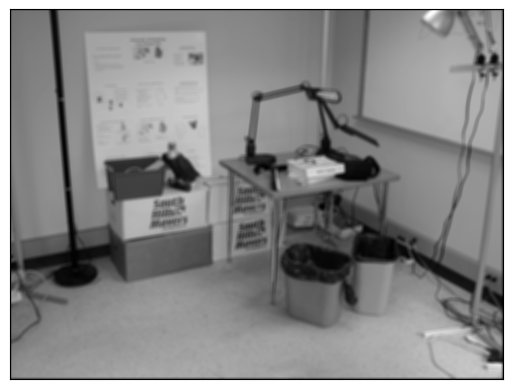

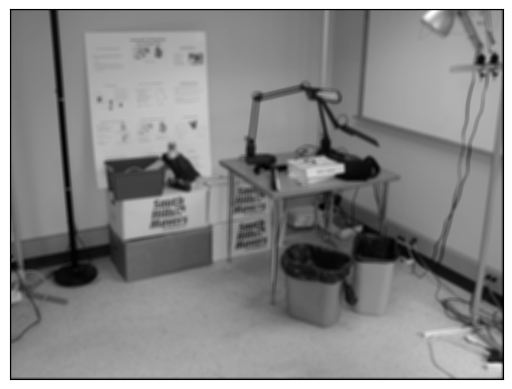

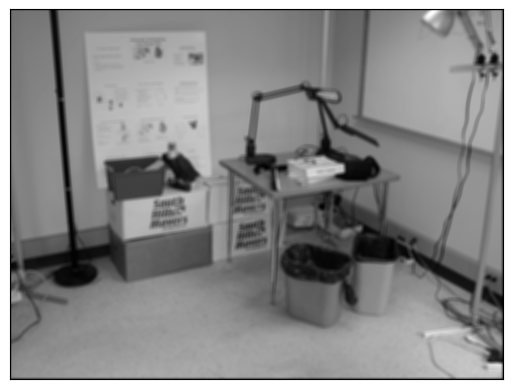

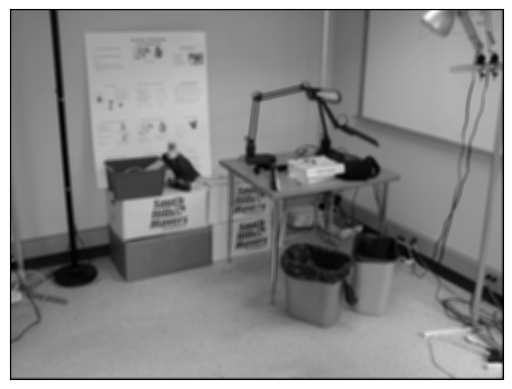

In [65]:
for gaussian_image in scale_space: 
    show_binary_image(gaussian_image)

Step 2. Create DoG Stack 

In [66]:
def create_DoG_stack(scale_space: np.ndarray) -> np.ndarray:
    # Calculate the number of DoG images
    num_DoG_images = scale_space.shape[0] - 1
    # Initialize the DoG stack with one less image than the scale space
    DoG_stack = np.zeros((num_DoG_images, scale_space.shape[1], scale_space.shape[2]))
    # Compute the differences
    for i in range(num_DoG_images):
        DoG_stack[i] = scale_space[i] - scale_space[i+1]
    return DoG_stack
dog_space = create_DoG_stack(scale_space)

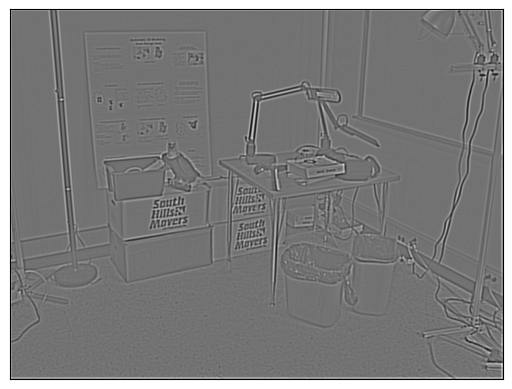

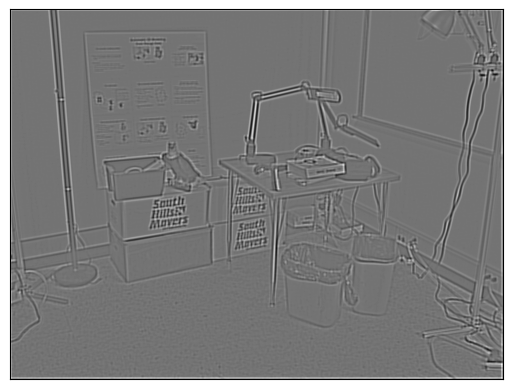

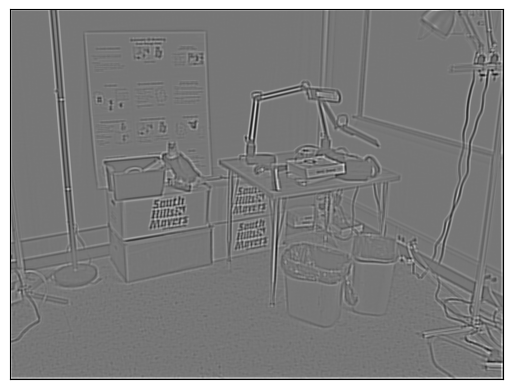

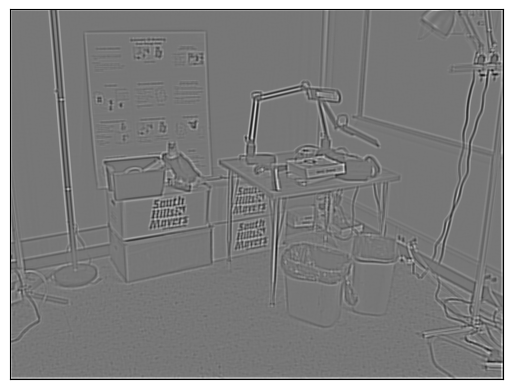

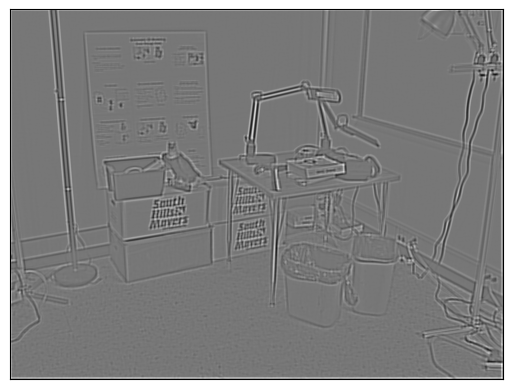

In [67]:
for dog in dog_space: 
    show_binary_image(dog)

Step 3. Local Extrema Detection 

In [68]:
import numpy as np

def detect_local_extrema(dog_stack: np.ndarray) -> np.ndarray:
    interest_points = []  # List to store the interest points as (z, y, x) tuples

    # Iterate over each slice, now including the first and last
    for idx in range(dog_stack.shape[0]):
        # Iterate over each pixel in the slice, excluding the borders
        for x in range(1, dog_stack.shape[1] - 1):
            for y in range(1, dog_stack.shape[2] - 1):
                # Determine the range for the z-axis comparison
                z_start = max(0, idx - 1)
                z_end = min(dog_stack.shape[0], idx + 2)
                
                # Extract the neighborhood, adjusting for edges
                neighborhood = dog_stack[z_start:z_end, x-1:x+2, y-1:y+2]
                
                # Find the value of the central pixel
                central_value = dog_stack[idx, x, y]
                
                # Check if the central pixel is a max or min in its neighborhood
                if central_value == np.max(neighborhood) and central_value > neighborhood.mean() or \
                   central_value == np.min(neighborhood) and central_value < neighborhood.mean():
                    # If it's a local extremum and significantly different from mean (to remove flat regions), add to list
                    interest_points.append((x, y))

    return np.array(interest_points)  # Convert list to array for convenience



interest_points = detect_local_extrema(dog_space)
interest_points


array([[  0,   1, 917],
       [  0,   1, 930],
       [  0,   1, 937],
       ...,
       [  4, 763, 834],
       [  4, 763, 936],
       [  4, 763, 979]])

In [69]:
interest_points.shape

(52345, 3)